# Jonathan Halverson
# Thursday, February 2, 2017
# Network analysis of US flights

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# airport coordinates taking from http://openflights.org/data.html
columns = ['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'Type', 'Source']
coords = pd.read_csv('airports.csv', header=None, names=columns)
coords.head(3)

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,Type,Source
0,1,Goroka,Goroka,Papua New Guinea,GKA,AYGA,-6.081689,145.391881,5282,10.0,U,Pacific/Port_Moresby
1,2,Madang,Madang,Papua New Guinea,MAG,AYMD,-5.207083,145.788700,20,10.0,U,Pacific/Port_Moresby
2,3,Mount Hagen,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789,144.295861,5388,10.0,U,Pacific/Port_Moresby


In [3]:
coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8107 entries, 0 to 8106
Data columns (total 12 columns):
AirportID    8107 non-null int64
Name         8107 non-null object
City         8107 non-null object
Country      8107 non-null object
IATA         5880 non-null object
ICAO         8043 non-null object
Latitude     8107 non-null float64
Longitude    8107 non-null float64
Altitude     8107 non-null int64
Timezone     8107 non-null float64
Type         8107 non-null object
Source       8107 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 760.1+ KB


In [4]:
coords[coords.IATA == 'LAX']

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,Type,Source
3385,3484,Los Angeles Intl,Los Angeles,United States,LAX,KLAX,33.942536,-118.408075,126,-8.0,A,America/Los_Angeles


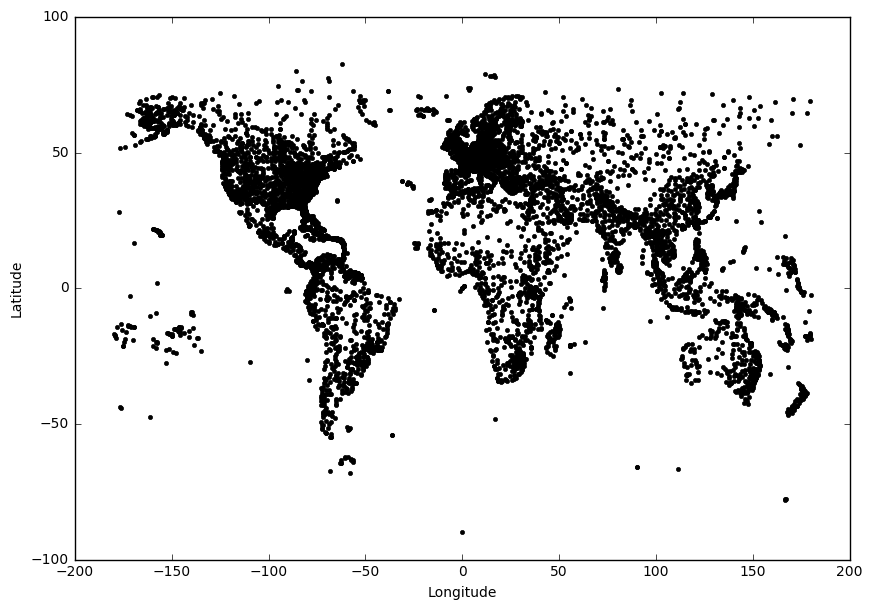

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(coords.Longitude, coords.Latitude, 'k.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

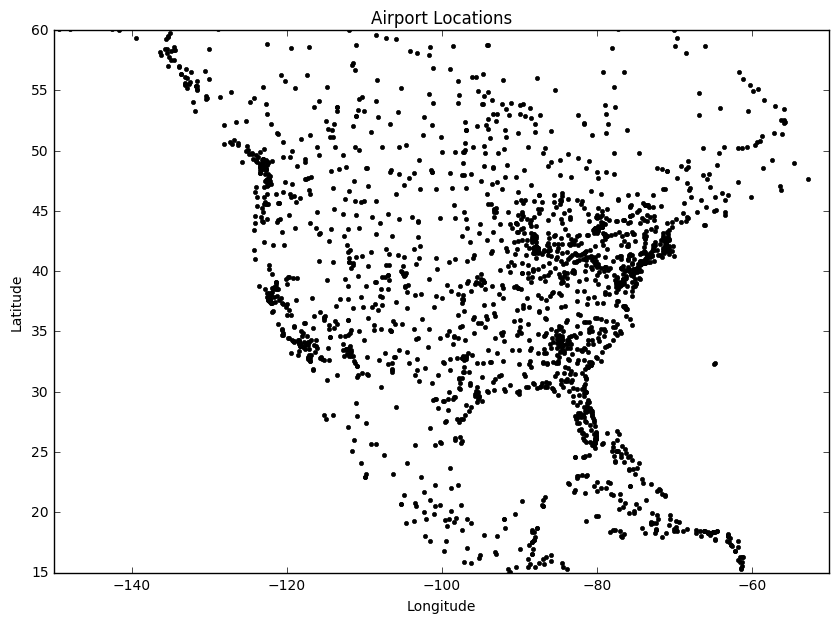

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(coords.Longitude, coords.Latitude, 'k.')
plt.xlim(-150, -50)
plt.ylim(15, 60)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Airport Locations')

In [7]:
columns = ['flight_date', 'airline_id', 'flight_num', 'origin', 'destination', 'departure_time', 'departure_delay', 'arrival_time', 'arrival_delay', 'air_time', 'distance']
flights = pd.read_csv('../hadoop/ontime/flights.csv', parse_dates=[0], header=None, names=columns)
flights.head(3)

,flight_date,airline_id,flight_num,origin,destination,departure_time,departure_delay,arrival_time,arrival_delay,air_time,distance
0,2014-04-01,19805,1,JFK,LAX,854,-6.0,1217,2.0,355.0,2475.0
1,2014-04-01,19805,2,LAX,JFK,944,14.0,1736,-29.0,269.0,2475.0
2,2014-04-01,19805,3,JFK,LAX,1224,-6.0,1614,39.0,371.0,2475.0


In [8]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476881 entries, 0 to 476880
Data columns (total 11 columns):
flight_date        476881 non-null datetime64[ns]
airline_id         476881 non-null int64
flight_num         476881 non-null int64
origin             476881 non-null object
destination        476881 non-null object
departure_time     476881 non-null int64
departure_delay    476881 non-null float64
arrival_time       476881 non-null int64
arrival_delay      476881 non-null float64
air_time           476881 non-null float64
distance           476881 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 40.0+ MB


In [9]:
df = pd.merge(flights, coords, left_on='origin', right_on='IATA', how='inner')
df.shape

(476881, 23)

In [10]:
df.head(3).transpose()

,0,1,2
flight_date,2014-04-01 00:00:00,2014-04-01 00:00:00,2014-04-01 00:00:00
airline_id,19805,19805,19805
flight_num,1,3,9
origin,JFK,JFK,JFK
destination,LAX,LAX,LAX
departure_time,854,1224,648
departure_delay,-6,-6,-7
arrival_time,1217,1614,1029
arrival_delay,2,39,19
air_time,355,371,365


In [12]:
def f(x):
    return (x['origin'], x['destination'])
df['edges'] = df[['origin', 'destination']].apply(f, axis=1)

In [14]:
df.edges[:5]

0    (JFK, LAX)
1    (JFK, LAX)
2    (JFK, LAX)
3    (JFK, LAX)
4    (JFK, LAX)
Name: edges, dtype: object